<a href="https://colab.research.google.com/github/MarathaAshhhh/Object_Removal/blob/main/ObjectRemoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import models
from PIL import Image
import cv2

In [ ]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

2022-07-09 15:47:16 URL:https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg [128686/128686] -> "horse.png" [1]


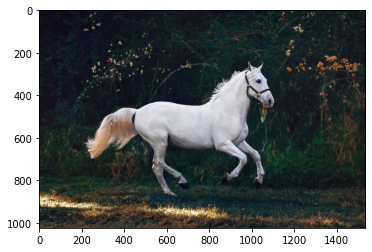

torch.Size([3, 1024, 1536])
torch.Size([3, 256, 384])


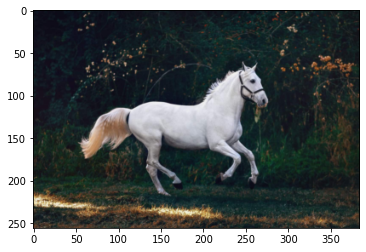

In [ ]:
!wget -nv https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg -O horse.png
img = Image.open('./horse.png')
plt.imshow(img); plt.show()
T = transforms.ToPILImage()
T1 = transforms.ToTensor()
img_T1 = T1(img)
print(img_T1.shape)
T3 = transforms.Resize(256)
img_T3 = T3(img)
plt.imshow(img_T3)
img_T11 = T1(img_T3)
print(img_T11.shape)


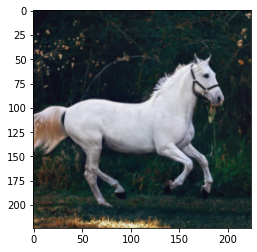

torch.Size([3, 224, 224])


In [ ]:
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
trans = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
inp = transform(img).unsqueeze(0)
new_img = trans(img)
plt.imshow(new_img); plt.show()
im = T1(new_img)
#T = transforms.ToPILImage()
#im_PIL = T(im)
im_numpy = im.numpy()
print(im.shape)


In [ ]:
out = dlab(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


In [ ]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[ 0 13]


In [ ]:
def decode_segmap(image, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)   
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb


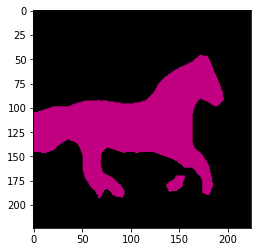

In [ ]:
from torchvision.transforms.transforms import ToPILImage
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()
T2 = transforms.Compose([ ToPILImage() ,transforms.Resize(256), transforms.CenterCrop(224)]) 

(1024, 1536, 3)


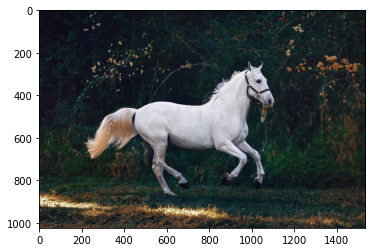

In [ ]:
ori_img_bgr = cv2.imread("horse.png" , cv2.IMREAD_COLOR)
ori_img_rgb = ori_img_bgr[:,:,::-1]
plt.imshow(ori_img_rgb)
print(ori_img_rgb.shape)

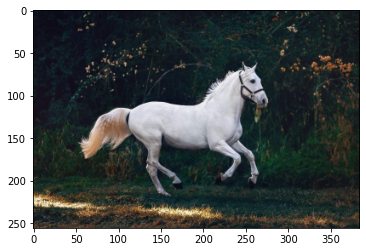

In [ ]:
desired_width = 384    #width of image_T11
desired_height = 256   #height of image_T11
dim = (desired_width, desired_height)
resized_ori_img = cv2.resize(ori_img_rgb , dsize=dim, interpolation=cv2.INTER_AREA)
plt.imshow(resized_ori_img)


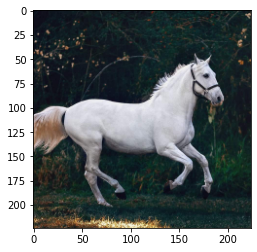

In [ ]:
ori_img = resized_ori_img[16:240 , 80:304]
plt.imshow(ori_img)

In [ ]:
desired_width = 224
desired_height = 224
dim1 = (desired_width, desired_height)
resized_rgb = cv2.resize(rgb, dsize=dim1, interpolation=cv2.INTER_AREA)
plt.imshow(resized_rgb, cmap='gray')
print(resized_rgb.shape)

(224, 224, 3)


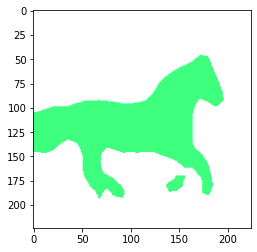

In [18]:
img_mask = cv2.bitwise_not(resized_rgb)
plt.imshow(img_mask,cmap="gray")
print(img_mask.shape)

(224, 224)
(224, 224)


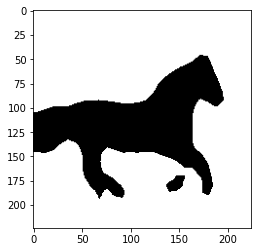

In [19]:
img_gray = cv2.cvtColor(img_mask, cv2.COLOR_RGB2GRAY)

# Apply global thresholding to creat a binary mask of the logo
retval, img_mask = cv2.threshold(img_gray,250,255,cv2.THRESH_BINARY)

plt.imshow(img_mask,cmap="gray")
print(img_gray.shape)
print(img_mask.shape)

(224, 224)


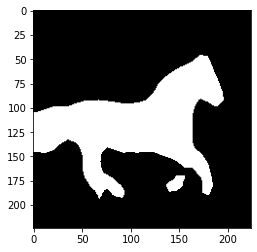

In [20]:
img_mask_inv = cv2.bitwise_not(img_mask)
plt.imshow(img_mask_inv,cmap="gray")
print(img_mask_inv.shape)

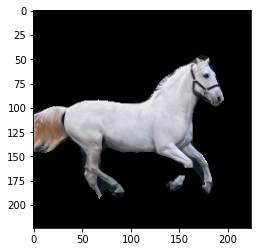

In [21]:
result = cv2.bitwise_and(ori_img, ori_img , mask = img_mask_inv)
plt.imshow(result)